# Experiments for Toy Classification Problem

## The input to the gate is the encoded dataset.

In [6]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # colormaps 
                                        
%matplotlib inline

In [7]:
import seaborn as sns
import numpy as np
from statistics import mean
from math import ceil, sin, cos, radians
from collections import OrderedDict
import os
import pandas as pd
from pprint import pprint
from copy import deepcopy

In [8]:
import torch

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [10]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('device', device)
else:
    device = torch.device("cpu")
    print('device', device)

device cuda:0


In [11]:
# import MoE architecture models
from moe_models.moe_em_model import moe_em_model
from moe_models.moe_expectation_model import moe_expectation_model
from moe_models.moe_pre_softmax_expectation_model import moe_pre_softmax_expectation_model
from moe_models.moe_stochastic_model import moe_stochastic_model, moe_stochastic_loss
from helper.moe_models import cross_entropy_loss

device cuda:0
device cuda:0
device cuda:0
device cuda:0
device cuda:0


In [12]:
# Toy data generator
from helper import data_generator

device cuda:0


In [13]:
# Visualisation functions
from helper.visualise_results_toy_classification import *

device cuda:0


### NOTE: Pre-trained models are provided to check the results of all the experiments if you do not have the time to train all the models. 

## Generate dataset for training

In [14]:
# Paths to where the trained models and figures will be stored. You can change this as you see fit.
fig_path = '../figures/test'
model_path = '../models/test'
pre_trained_model_path = '../models/pre_trained'

if not os.path.exists(fig_path):
    os.mkdir(fig_path)
if not os.path.exists(model_path):
    os.mkdir(model_path)

In [15]:
palette = ['tab:purple', 'tab:green', 'tab:orange','tab:pink', 'tab:olive','tab:brown', 'tab:cyan']

In [16]:
def plot_data(X, y, num_classes, dataset, path):
    f, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,8))
    sns.scatterplot(x=X[:,0],y=X[:,1],hue=y,palette=palette[0:num_classes], ax=ax)
    ax.set_title("2D "+str(num_classes)+" classes toy classification dataset")
    plt.ylabel('Dim 2')
    plt.xlabel('Dim 1')
    plt.savefig(os.path.join(path, dataset+'_'+str(num_classes)+'.png'))

In [17]:
dataset = 'multi_class'

NUM CLASSES 6
4058803790
Training set size: 2400 Test set size: 600


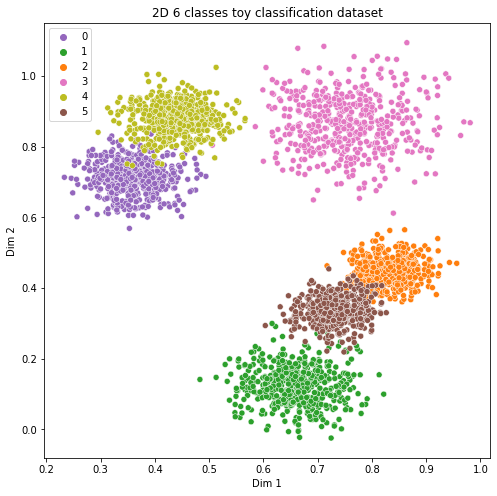

In [18]:
X, y, trainset, trainloader, testset, testloader, num_classes = data_generator.generate_data(dataset, 3000,32,6)
plot_data(X, y, num_classes, dataset, fig_path)
print('Training set size:',len(trainset), 'Test set size:', len(testset))

## Define expert and gate networks

In [19]:
# Initialize expert and gate networks to default parameters
fill = 'rand'
fill = 'rand'

In [20]:
# Simple linear expert network
class expert_layers(nn.Module):
    def __init__(self, masks,num_classes, output, fill='rand', fill_w=None, fill_b=None):
        super(expert_layers, self).__init__()
        linear_1 = nn.Linear(2,output)
        if not fill == 'rand':
            linear_1.weight.data = fill_w
            linear_1.bias.data = fill_b
        self.model = nn.Sequential(OrderedDict({
                    'linear_1':linear_1,
                    'softmax': nn.Softmax(dim=1)
                    })
                ) 
        self.masks = masks
        self.output = output
        self.num_classes = num_classes
        
    def forward(self, input):
        output = self.model(input)
        if not self.masks is None:
            mask = torch.zeros(output.shape[0],self.num_classes)
            for m, i in zip(self.masks, range(self.output)):
                mask[:,m] = output[:,i] 
            return mask.to(device)
        return output


In [21]:
# Simple linear expert network for pre-softmax architecture. Note that the output of the network is the pre-softmax output
class expert_layers_presoftmax(nn.Module):
    def __init__(self, masks, num_classes, output, fill='rand', fill_w=None, fill_b=None):
        super(expert_layers_presoftmax, self).__init__()
        linear_1 = nn.Linear(2,output)
        if not fill == 'rand':
            linear_1.weight.data = fill_w
            linear_1.bias.data = fill_b
        self.model = nn.Sequential(OrderedDict({
                    'linear_1':linear_1
                    })
                ) 
        self.masks = masks
        self.output = output
        self.num_classes = num_classes
        
    def forward(self, input):
        output = self.model(input)
        if not self.masks is None:
            mask = torch.zeros(output.shape[0],self.num_classes)
            for m, i in zip(self.masks, range(self.output)):
                mask[:,m] = output[:,i] 
            return mask.to(device)
        return output

In [22]:
# create a set of experts
def experts(num_experts, masks, total_num_classes, num_classes_per_expert, expert_layers_type=expert_layers):
    models = []
    for i in range(num_experts):
        models.append(expert_layers_type(masks[i], total_num_classes, num_classes_per_expert[i], fill=fill))
    return nn.ModuleList(models)

In [23]:
# Simple linear gate expert
class gate_layers(nn.Module):
    def __init__(self, num_experts, fill='rand', fill_w=None, fill_b=None):
        super(gate_layers, self).__init__()
        linear_1 = nn.Linear(2,num_experts)
        if not fill == 'rand':
            linear_1.weight.data = fill_w
            linear_1.bias.data = fill_b
        self.model = nn.Sequential(OrderedDict({
                    'linear_1':linear_1
                    })
                )
    def forward(self, inputs, T=1.0):
        t = self.model(inputs)
        return F.softmax(t/T, dim=1)

In [24]:
# Simple linear gate expert
class gate_decoder(nn.Module):
    def __init__(self, num_experts):
        super(gate_decoder, self).__init__()
        linear_1 = nn.Linear(num_experts,16)
        linear_2 = nn.Linear(16, 2)
        self.model = nn.Sequential(OrderedDict({
                    'linear_1':linear_1,
                    'linear_2':linear_2
                    })
                )
    def forward(self, inputs, T=1.0):
        t = self.model(inputs)
        return t

## Initialize configurations and helper functions

In [25]:
# Compute predicted label accuracy
def accuracy(out, yb, mean=True):
    preds = torch.argmax(out, dim=1).to(device)
    if mean:
        return (preds == yb).float().mean()
    else:
        return (preds == yb).float()

In [26]:
w_importance=0.0 # flag to indicate setting or unsetting of gate coefficient of variation regualarization 
w_ortho = 0.0

# Generate the file names for models and figures
def generate_plot_file(dataset, specific):
    plot_file = dataset
    if w_importance > 0:
        plot_file += '_importance_'+str(w_importance)
    plot_file += '_'+str(fill)
    plot_file += '_'+specific
    
    return plot_file


## Train Encoder-Decoder

In [27]:
def train_encoder_decoder(num_experts):

    num_epochs = 20

    encoder = gate_layers(num_experts).to(device)
    decoder = gate_decoder(num_experts).to(device)

    loss_criterion = nn.MSELoss()
    optimizer = optim.RMSprop(encoder.parameters(),
                                      lr=0.01, momentum=0.9)
    optimizer.add_param_group({'params': decoder.parameters()})
    for epoch in range(num_epochs):
        running_loss = 0.0
        train_running_accuracy = 0.0
        num_batches = 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            e_outputs = encoder(inputs)
            outputs = decoder(e_outputs)

            optimizer.zero_grad()
            loss = loss_criterion(outputs, inputs)

            loss.backward()

            optimizer.step()

            running_loss += loss.item()

            num_batches += 1

        print('Training Encoder: epoch %d' % epoch,
              'training loss %.2f' % (running_loss/num_batches))
    return encoder

## Experiment 1: Train the different MoE architectures with a linear gate and linear un-trained experts 

### This experiment shows what the gate and the experts learn and the gate task decomposition between the experts.

In [24]:
# Set the number of experts to be used for the experiment
total_experts = 5

In [25]:
num_epochs = 20

In [26]:
model_1 = 'multi_class_linear_expert_gate_encoder'

In [ ]:
# Train the model. NOTE: There is a pre-trained model you can load to test the results if you do not want to 
# train the model
models = {
#         'moe_em_model':{'model':moe_em_model,'loss':cross_entropy_loss,'experts':{}},
#         'moe_pre_softmax_expectation_model':{'model':moe_pre_softmax_expectation_model,'loss':cross_entropy_loss,'experts':{}},
        'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}},
#         'moe_stochastic_model':{'model':moe_stochastic_model, 'loss':moe_stochastic_loss(cross_entropy_loss),'experts':{}}
     }
for key, val in models.items():
    print('Model:', key)
    for num_experts in range(2, total_experts+1):
        print('Number of experts ', num_experts)
        if 'pre_softmax' in key:
            expert_models = experts(num_experts, [None]*num_experts, num_classes, [num_classes]*num_experts, expert_layers_presoftmax)
        else:
            expert_models = experts(num_experts, [None]*num_experts, num_classes, [num_classes]*num_experts)
        gate_model = train_encoder_decoder(num_experts)
        moe_model = val['model'](num_experts, num_classes, augment=0, attention_flag=0, 
                                 experts=expert_models, gate=gate_model)
        params = [p.numel() for p in moe_model.parameters() if p.requires_grad]
        print('model params:', sum(params))
        optimizer_moe = optim.RMSprop(moe_model.parameters(),
                                  lr=0.01, momentum=0.9)

        hist = moe_model.train(trainloader, testloader, val['loss'], optimizer_moe,  
                               accuracy=accuracy, epochs=num_epochs)
        val['experts'][num_experts] = {'model':moe_model, 'history':hist}
        
# Save the trained model
plot_file = generate_plot_file(model_1, str(num_classes)+'_'+str(total_experts)+'_model.pt')
torch.save(models,open(os.path.join(model_path, plot_file),'wb'))    


In [28]:
# Visualise the MoE model and Expert classification outputs for test data for model_1

# Generate a mesh grid to plot the decision boundaries

def visualise(model_name):
    generated_data = generate_meshgrid(X).to(device)

    model_1 = model_name

    total_experts = 5
    plot_file = generate_plot_file(model_1, str(num_classes)+'_'+str(total_experts)+'_model.pt')
    print('Loading model:', plot_file)

    # Load the saved model file. NOTE: Here we load the already saved model for 5 experts reported in the paper from 
    # 'pre_trained_model_path'. You can change this to the 'model_path' to load the model you build above.
    models = torch.load(os.path.join(model_path, plot_file), map_location=device)

    print('\nTest data class predictions by the trained MoE models and the individual experts along with the samples gated to the expert by the gate (shaded regions). Red \'x\' are the mis-classified samples.')

    image_file = generate_plot_file(model_1, 'gate_decisions_test_'+str(num_classes))
    filename = os.path.join(fig_path, image_file)
    visualize(models, range(2,total_experts+1), num_classes, generated_data, 
                testset[:][0].to(device), testset[:][1].to(device), filename=filename)

Loading model: multi_class_linear_expert_gate_encoder_rand_6_5_model.pt

Test data class predictions by the trained MoE models and the individual experts along with the samples gated to the expert by the gate (shaded regions). Red 'x' are the mis-classified samples.

 Model: moe_expectation_model 2 Experts


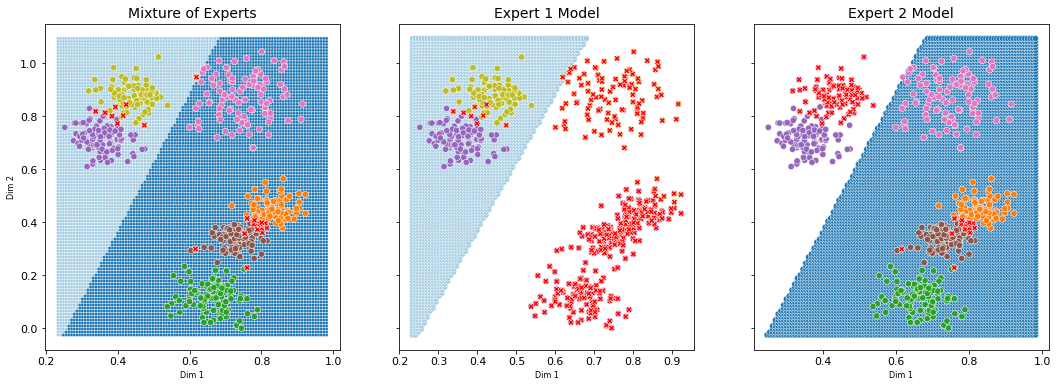


 Model: moe_expectation_model 3 Experts


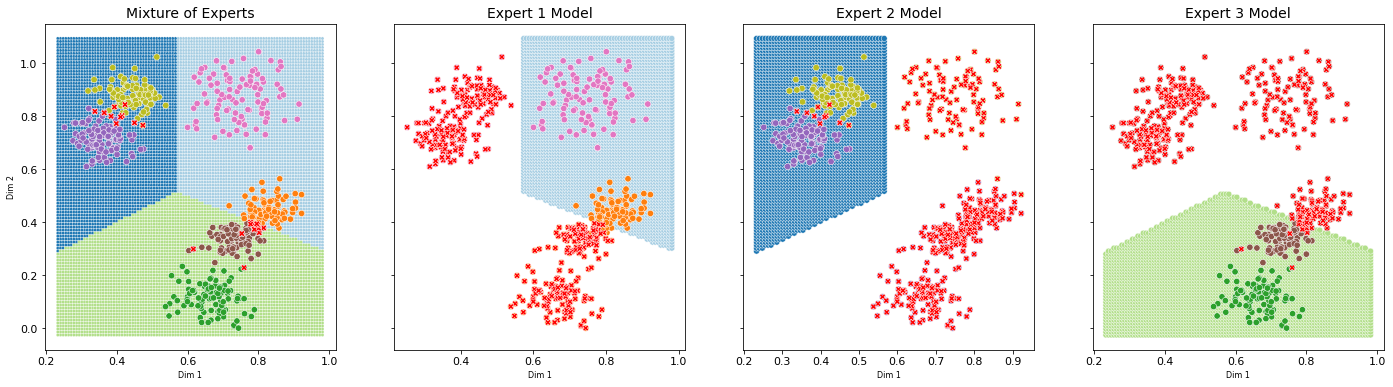


 Model: moe_expectation_model 4 Experts


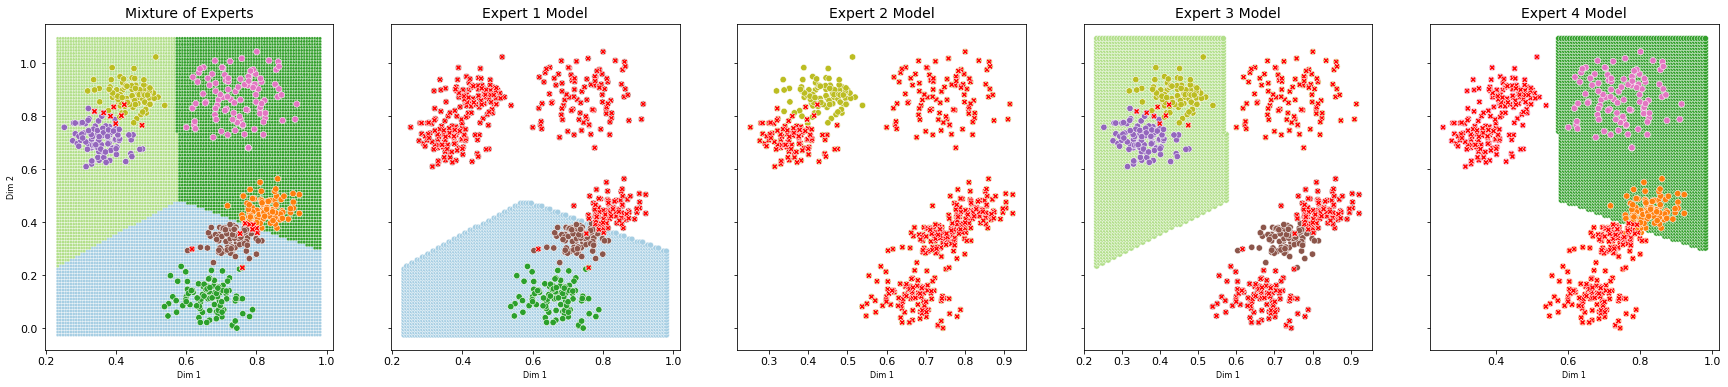


 Model: moe_expectation_model 5 Experts


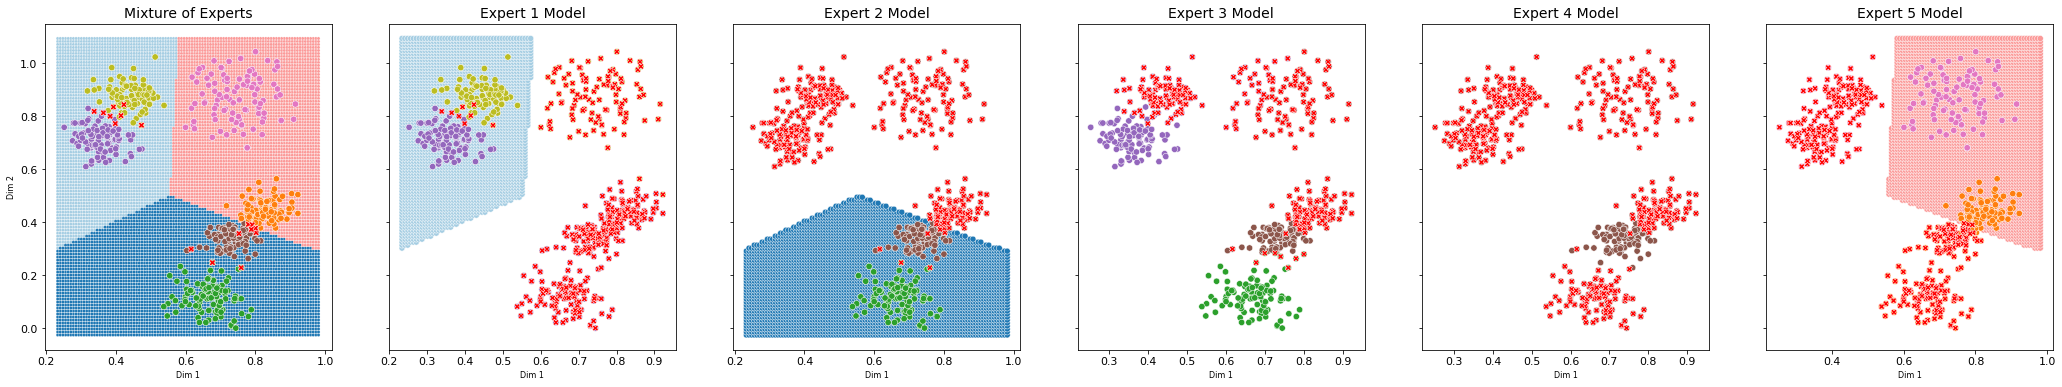

In [29]:
visualise('multi_class_linear_expert_gate_encoder')

In [28]:
model_2 = 'multi_class_linear_expert_gate'

In [30]:
total_experts = 5

In [32]:
num_epochs = 20

In [33]:
# Train the model. NOTE: There is a pre-trained model you can load to test the results if you do not want to 
# train the model
models = {
#         'moe_em_model':{'model':moe_em_model,'loss':cross_entropy_loss,'experts':{}},
#         'moe_pre_softmax_expectation_model':{'model':moe_pre_softmax_expectation_model,'loss':cross_entropy_loss,'experts':{}},
        'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}},
#         'moe_stochastic_model':{'model':moe_stochastic_model, 'loss':moe_stochastic_loss(cross_entropy_loss),'experts':{}}
     }
for key, val in models.items():
    print('Model:', key)
    for num_experts in range(2, total_experts+1):
        print('Number of experts ', num_experts)
        if 'pre_softmax' in key:
            expert_models = experts(num_experts, [None]*num_experts, num_classes, [num_classes]*num_experts, expert_layers_presoftmax)
        else:
            expert_models = experts(num_experts, [None]*num_experts, num_classes, [num_classes]*num_experts)
        gate_model = gate_layers(num_experts, fill)
        #plot_boundary_components(gate_model)
        moe_model = val['model'](num_experts, num_classes, augment=0, attention_flag=0, 
                                 experts=expert_models, gate=gate_model)
        params = [p.numel() for p in moe_model.parameters() if p.requires_grad]
        print('model params:', sum(params))
        optimizer_moe = optim.RMSprop(moe_model.parameters(),
                                  lr=0.01, momentum=0.9)

        hist = moe_model.train(trainloader, testloader, val['loss'], optimizer_moe,  
                               w_importance, w_ideal_gate=0, 
                               accuracy=accuracy, epochs=num_epochs)
        val['experts'][num_experts] = {'model':moe_model, 'history':hist}
        
# Save the trained model
plot_file = generate_plot_file(model_2, str(num_classes)+'_'+str(total_experts)+'_model.pt')
torch.save(models,open(os.path.join(model_path, plot_file),'wb'))    


Model: moe_expectation_model
Number of experts  2
model params: 42
epoch 0 training loss 0.90 , training accuracy 0.69 , test accuracy 0.79
epoch 1 training loss 0.56 , training accuracy 0.91 , test accuracy 0.92
epoch 2 training loss 0.46 , training accuracy 0.95 , test accuracy 0.96
epoch 3 training loss 0.40 , training accuracy 0.94 , test accuracy 0.89
epoch 4 training loss 0.36 , training accuracy 0.95 , test accuracy 0.95
epoch 5 training loss 0.32 , training accuracy 0.96 , test accuracy 0.93
epoch 6 training loss 0.29 , training accuracy 0.96 , test accuracy 0.95
epoch 7 training loss 0.27 , training accuracy 0.97 , test accuracy 0.95
epoch 8 training loss 0.25 , training accuracy 0.97 , test accuracy 0.96
epoch 9 training loss 0.23 , training accuracy 0.97 , test accuracy 0.97
epoch 10 training loss 0.22 , training accuracy 0.96 , test accuracy 0.97
epoch 11 training loss 0.20 , training accuracy 0.97 , test accuracy 0.97
epoch 12 training loss 0.19 , training accuracy 0.97 , 

Loading model: multi_class_linear_expert_gate_rand_6_5_model.pt

Test data class predictions by the trained MoE models and the individual experts along with the samples gated to the expert by the gate (shaded regions). Red 'x' are the mis-classified samples.

 Model: moe_expectation_model 2 Experts


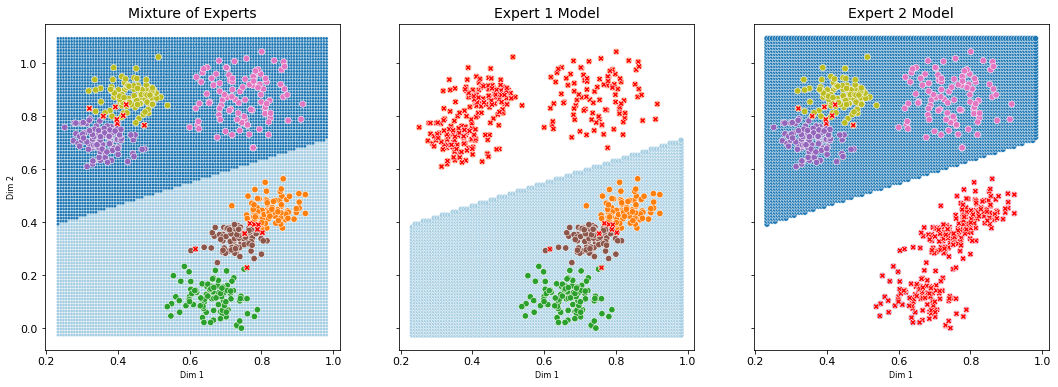


 Model: moe_expectation_model 3 Experts


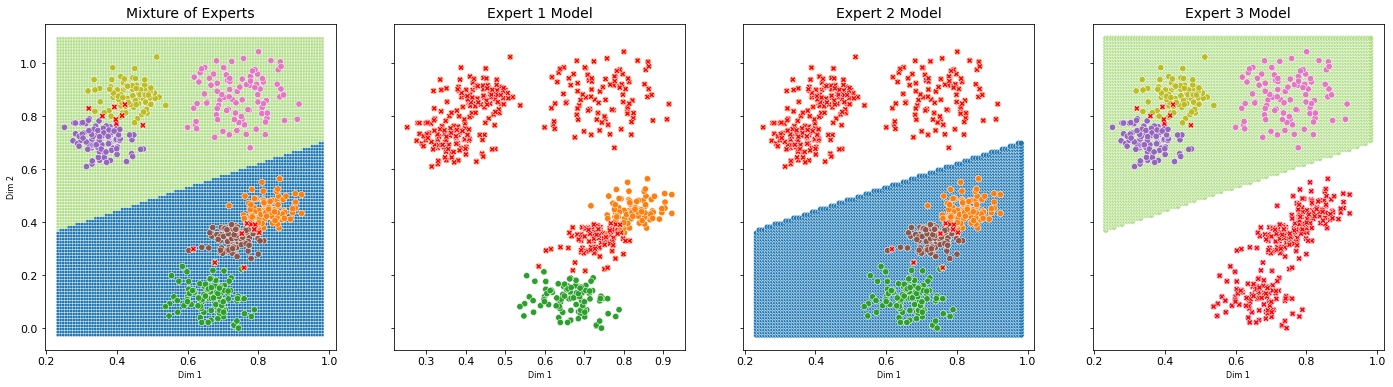


 Model: moe_expectation_model 4 Experts


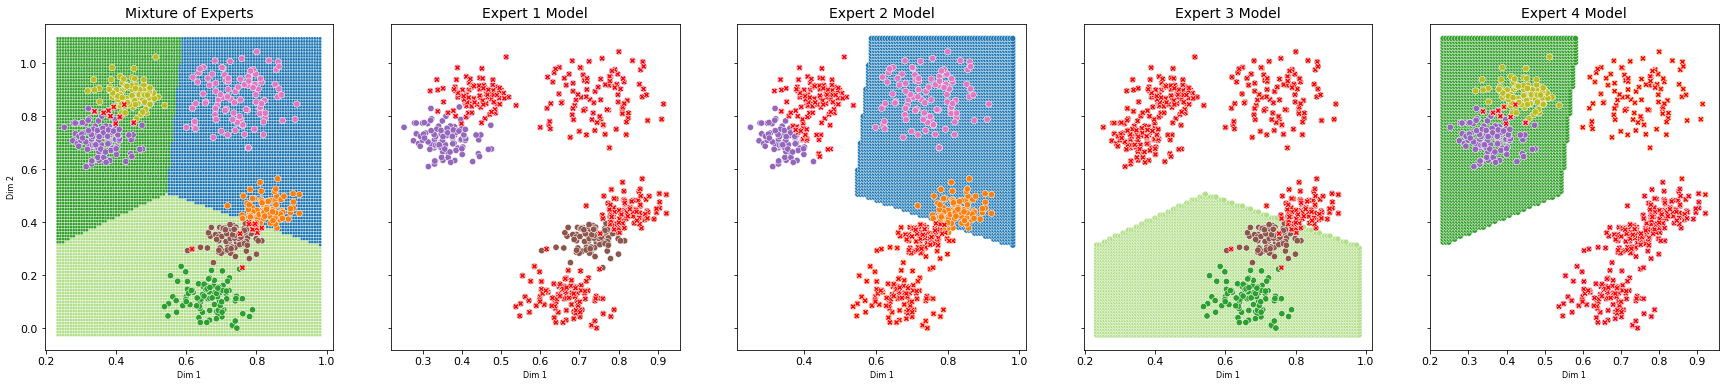


 Model: moe_expectation_model 5 Experts


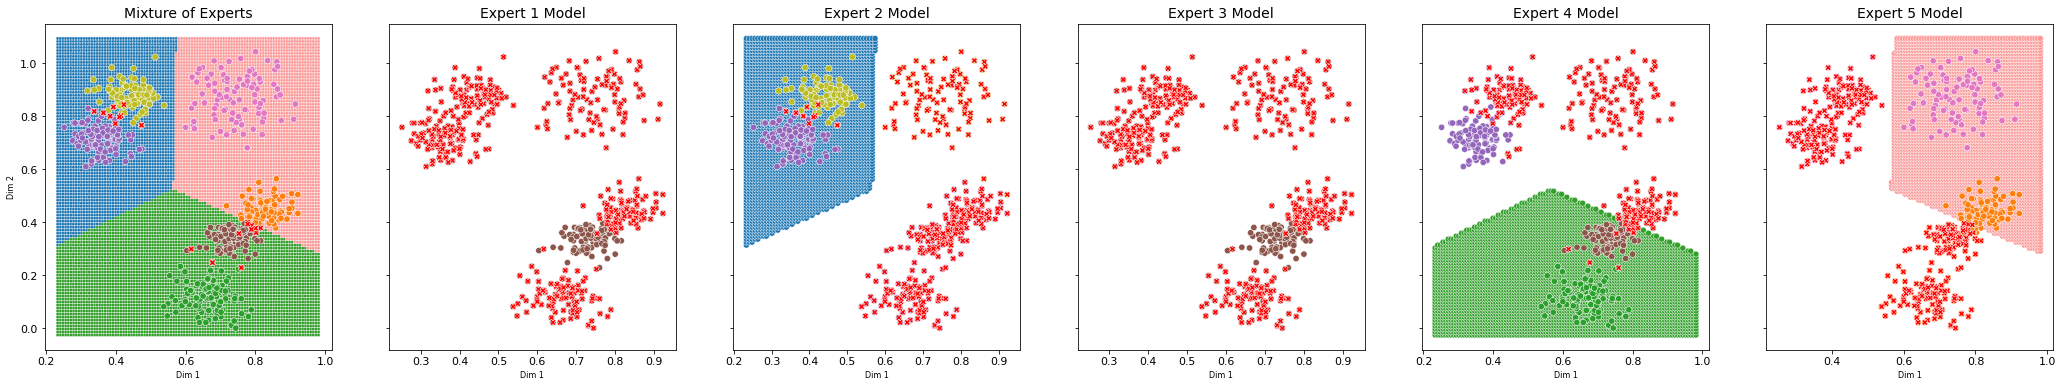

In [32]:
visualise('multi_class_linear_expert_gate')

## Experiment 2: Train 2 experts with different learning rates

### This experiment checks the sample distribution and loss convergence during training to test the end-to-end joint training of the gate and experts.

In [27]:
total_experts = 2

In [28]:
num_epochs = 30

In [29]:
model_2 =  'multi_class_linear_expert_gate'

In [38]:
# Train the 2 expert model
n_runs = 10
n_models = []
for n_run in range(n_runs):
    print('RUN ', n_run)
    models = {
            'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}},
         }
    for key, val in models.items():
        print('Model:', key)

        print('Number of experts ', total_experts)
        
        expert_models = experts(total_experts, [None]*total_experts, num_classes, [num_classes]*total_experts)

        gate_model = gate_layers(num_classes, total_experts, fill)

        moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0, experts=expert_models, gate=gate_model)

        params = [p.numel() for p in moe_model.parameters() if p.requires_grad]
        print('model params:', sum(params))

        optimizer_moe = optim.RMSprop(gate_model.parameters(),
                                  lr=0.01, momentum=0.9)
        
        # Set different learning rates for the experts
        lr = [0.01,0.0001]
        for i, expert in enumerate(expert_models):
            optimizer_moe.add_param_group({'params': expert.parameters(), 'lr':lr[i]})

        hist = moe_model.train(trainloader, testloader, val['loss'], optimizer_moe, 
                               None, None,  
                               w_importance, w_ortho=0, w_ideal_gate=0, 
                               accuracy=accuracy, epochs=num_epochs)
        val['experts'][total_experts] = {'model':moe_model, 'history':hist}
    n_models.append(models)
    
# Save the trained model
plot_file = generate_plot_file(model_2, str(num_classes)+'_'+str(total_experts)+'_'+str(n_runs)+'_model.pt')
torch.save(n_models,open(os.path.join(model_path, plot_file),'wb'))    


RUN  0
Model: moe_expectation_model
Number of experts  2
model params: 42
epoch 0 training loss 1.01 , training accuracy 0.69 , test accuracy 0.82
epoch 1 training loss 0.64 , training accuracy 0.87 , test accuracy 0.87
epoch 2 training loss 0.55 , training accuracy 0.88 , test accuracy 0.92
epoch 3 training loss 0.47 , training accuracy 0.95 , test accuracy 0.95
epoch 4 training loss 0.42 , training accuracy 0.96 , test accuracy 0.98
epoch 5 training loss 0.38 , training accuracy 0.95 , test accuracy 0.96
epoch 6 training loss 0.35 , training accuracy 0.96 , test accuracy 0.95
epoch 7 training loss 0.33 , training accuracy 0.97 , test accuracy 0.95
epoch 8 training loss 0.31 , training accuracy 0.96 , test accuracy 0.96
epoch 9 training loss 0.28 , training accuracy 0.97 , test accuracy 0.97
epoch 10 training loss 0.26 , training accuracy 0.97 , test accuracy 0.97
epoch 11 training loss 0.25 , training accuracy 0.97 , test accuracy 0.97
epoch 12 training loss 0.24 , training accuracy 

Model: multi_class_linear_expert_gate_rand_6_2_10_model.pt

Training sample distributions of 2 linear experts with different learning rates.


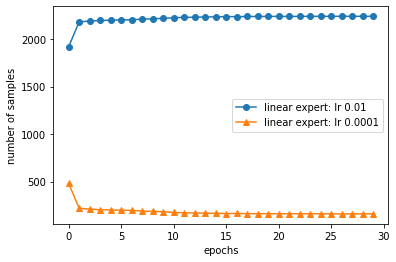


Training loss of 2 linear experts with different learning rates.


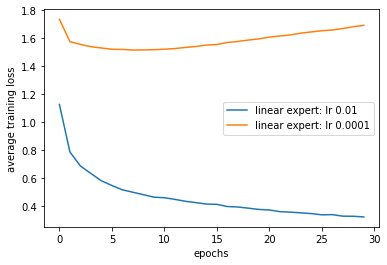

In [29]:
# Plot the training sample distribution and loss for the 10 runs above

model_2 =  'multi_class_linear_expert_gate'
num_epochs = 30
n_runs = 10
total_experts = 2
plot_file = generate_plot_file(model_2, str(num_classes)+'_'+str(total_experts)+'_'+str(n_runs)+'_model.pt')
print('Model:', plot_file)

# Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
# model you build above
n_models = torch.load(open(os.path.join(pre_trained_model_path, plot_file),'rb'), map_location=device)    

history_samples = []
history_loss = []
for model in n_models:
    expert_samples = model['moe_expectation_model']['experts'][2]['history']['exp_samples']
    expert_loss = model['moe_expectation_model']['experts'][2]['history']['expert_sample_loss']
    history_samples.append(expert_samples)
    history_loss.append(expert_loss)

exp_samples = np.asarray(history_samples)
exp_loss = np.asarray(history_loss)

# Plot training sample distribution
print('\nTraining sample distributions of 2 linear experts with different learning rates.')
plt.plot(range(num_epochs), np.mean(exp_samples[:,:,0], axis=0), marker='o',color='tab:blue')
plt.plot(range(num_epochs), np.mean(exp_samples[:,:,1], axis=0), marker='^',color='tab:orange')
plt.legend(['linear expert: lr 0.01', 'linear expert: lr 0.0001'])
plt.xlabel('epochs')
plt.ylabel('number of samples')
image_file = generate_plot_file(model_2, 'linear_vs_linear_samples_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
plt.savefig(os.path.join(fig_path, image_file))
plt.show()

# Plot training loss 
print('\nTraining loss of 2 linear experts with different learning rates.')
plt.plot(range(num_epochs), np.mean(exp_loss[:,:,0], axis=0))
plt.plot(range(num_epochs), np.mean(exp_loss[:,:,1], axis=0))
plt.legend(['linear expert: lr 0.01', 'linear expert: lr 0.0001'])
plt.xlabel('epochs')
plt.ylabel('average training loss')
image_file = generate_plot_file(model_2, 'linear_vs_linear_loss_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
plt.savefig(os.path.join(fig_path, image_file))
plt.show()